# Deep learning with ICCD images of plasma plumes generated during pulsed laser deposition for anomaly detection

#### Sumner B. Harris

This notebook is designed to provide a functional example of using (2+1)D CNNs to extract deep features from ICCD image sequences for real-time anomaly detection during pulsed laser deposition (PLD).

Start by importing the required packages:

In [1]:
# Import some basics
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Import our custom modules
import ICCDutils
import models

# Import Torch stuff
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

## Define the dataset class

In [2]:
class PLDdataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform, target_params, augment=True):
        self.df = dataframe
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get growth parameters
        params = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'T'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        
        # get targets
        if target_params == 'anomaly':
            target = torch.tensor([self.df.loc[idx,'P'],self.df.loc[idx,'E1'],self.df.loc[idx,'E2']],dtype=torch.float32)
        if target_params == 'growth':
            target = torch.tensor([self.df.loc[idx,'s0'],self.df.loc[idx,'s1'],self.df.loc[idx,'J']],dtype=torch.float32)

        # get ICCD image sequence
        image1 = torch.tensor(self.df.loc[idx,'ICCD'],dtype=torch.float32)

        if self.augment:
            image1 = self.transform(image1)      
            # add measurement noise to parameters for augmentation
            params[0] = params[0] + torch.randn(1)*2*np.sqrt(params[0]*0.00125) # account for 2 sigma, 0.25% baratron accuracy
            params[1] = params[1] + torch.randn(1)*2*np.sqrt(params[1]*0.0075)# account for 2 sigma, 1.5% temperature
            params[2] = params[2] + torch.randn(1)*2*np.sqrt(params[2]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy
            params[3] = params[3] + torch.randn(1)*2*np.sqrt(params[3]*0.0075)# account for 2 sigma, 1.5% laser stability accuracy

        return image1, params, target

## Make a helper function to load the data and split into training and validation sets

In [3]:
def load_data(datafile, target_params, normalize_PTE1E2, train_percent=70):
    # Create a transform for the ICCD images
    transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
    
    # load the full data from the json file
    df = ICCDutils.load_df(datafile, normalize_PTE1E2=normalize_PTE1E2)
    
    train_number = int(len(df)*train_percent/100)
    val_number = len(df)-train_number
    print('Total number of samples: {}'.format(len(df)))
    print('Number of training samples: {}\nNumber of validation samples: {}'.format(train_number, val_number))
    
    # instantiate the PLDdataset class
    dataset = PLDdataset(df, transform, target_params)
    
    # set a seed for reproducibility
    generator = torch.Generator().manual_seed(42)
    
    # randomly split the data into training and validation sets
    train_data, val_data = random_split(dataset,[train_number,val_number],generator=generator)
    
    return train_data, val_data

# Define the training function

In [4]:
def model_train_best(config, target_params, normalize_PTE1E2, chk_name):
    train_loss_list = []
    test_loss_list = []
    r2_list = []
    print("I'M TRAINING, I'M TRAINING!!")
    model = models.ICCDNet(l1=config['l1'],l2=config['l2'])
    
    device = 'cpu'
    if torch.cuda.is_available():
        print('Using GPU.')
        device = "cuda:0"    
        if torch.cuda.device_count() > 1:
            print('Using multiple GPUs.')
            model = nn.DataParallel(model)
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=config['lr'],amsgrad=True,weight_decay=config['weight_decay'])
    
    BATCH_SIZE = 88
    train_data, val_data = load_data(datafile, target_params, normalize_PTE1E2, train_percent=70)
    
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

    #print('Total image feature params:',sum(p.numel() for p in model.ICCD_features_.parameters()))
    #print('Total model params:',sum(p.numel() for p in model.parameters()))

    loss_values = []
    val_loss_values = []
    best_R2 = 0.0
    n_epochs=2000
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        for id_batch, (image1,params,target) in enumerate(train_loader):
            image1=image1.to(device)
            score = target.to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(image1)
            loss = loss_fn(y_pred, score)

            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_values.append(loss_train/len(train_loader))
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,
                                                          loss_train / len(train_loader)))
        
        train_pred, train_actuals = y_pred.cpu(), score.cpu()
        size = len(val_loader.dataset)
        num_batches = len(val_loader)
        test_loss = 0.0
        train_loss_list.append(loss_train)
        
        for (image1,params,target) in val_loader:
            with torch.no_grad():
                image1=image1.to(device)
                score = target.to(device)
                pred = model(image1)
                test_loss += loss_fn(pred, score).item()
                pr2 = pearsonr(score[:,0].cpu(), pred[:,0].cpu())[0]**2
                e1r2 = pearsonr(score[:,1].cpu(), pred[:,1].cpu())[0]**2
                e2r2 = pearsonr(score[:,2].cpu(), pred[:,2].cpu())[0]**2
                meanR2 = np.array([pr2,e1r2,e2r2]).mean()
                print('R2 values {:.4f}, {:.4f}, {:.4f}; mean R2={:.4f}'.format(pr2, e1r2, e2r2, meanR2))
                r2_list.append([pr2, e1r2, e2r2,meanR2])
                
        if meanR2>best_R2:
            print('New best, saving checkpoint...')
            best_R2 = meanR2
            best_val_predictions, best_val_actuals = pred.cpu().detach(), score.cpu().detach()
            best_train_predictions, best_train_actuals = train_pred.cpu().detach(), train_actuals.cpu().detach()
            
            torch.save(model.state_dict(), 'Model Checkpoints/'+chk_name+'.model')
        test_loss /= num_batches
        test_loss_list.append(test_loss)
        val_loss_values.append(test_loss)
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        
    return best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals

# Set up the configuration and train the model

In [5]:
config = {
        "l1": 64,
        "l2": 32,
        "lr": 0.0014129147018238114,
        "weight_decay": 0.0005312227896860003
}

datafile = 'PLD data.json'
target_params = 'anomaly'
normalize_PTE1E2 = False
chk_name = 'ICCD'

BATCH_SIZE = 88

best_R2, train_loss_list, test_loss_list, r2_list, best_train_predictions, best_train_actuals, best_val_predictions, best_val_actuals = model_train_best(config, target_params, normalize_PTE1E2, chk_name)

I'M TRAINING, I'M TRAINING!!
Using GPU.
Total number of samples: 127
Number of training samples: 88
Number of validation samples: 39
2023-11-16 13:51:26.705129 Epoch 1, Training loss 30680.0546875
R2 values 0.0588, 0.4427, 0.1075; mean R2=0.2030
New best, saving checkpoint...
Test Error: Avg loss: 29180.521484 

2023-11-16 13:51:27.193371 Epoch 2, Training loss 28397.470703125
R2 values 0.1228, 0.3491, 0.0222; mean R2=0.1647
Test Error: Avg loss: 26037.839844 

2023-11-16 13:51:27.643267 Epoch 3, Training loss 25401.208984375
R2 values 0.2517, 0.0627, 0.1890; mean R2=0.1678
Test Error: Avg loss: 22662.769531 

2023-11-16 13:51:28.098429 Epoch 4, Training loss 22143.275390625
R2 values 0.1401, 0.2917, 0.0016; mean R2=0.1444
Test Error: Avg loss: 18971.208984 

2023-11-16 13:51:28.552642 Epoch 5, Training loss 18805.052734375
R2 values 0.2325, 0.2008, 0.1240; mean R2=0.1858
Test Error: Avg loss: 15279.302734 

2023-11-16 13:51:29.008406 Epoch 6, Training loss 15322.384765625
R2 values 0.

2023-11-16 13:51:50.904149 Epoch 53, Training loss 4651.1279296875
R2 values 0.4044, 0.0171, 0.3415; mean R2=0.2544
Test Error: Avg loss: 4237.774902 

2023-11-16 13:51:51.361317 Epoch 54, Training loss 3934.934814453125
R2 values 0.4902, 0.0847, 0.1334; mean R2=0.2361
Test Error: Avg loss: 3877.361328 

2023-11-16 13:51:51.818632 Epoch 55, Training loss 4305.94677734375
R2 values 0.4355, 0.0726, 0.2496; mean R2=0.2526
Test Error: Avg loss: 4154.752930 

2023-11-16 13:51:52.276882 Epoch 56, Training loss 4404.58740234375
R2 values 0.5007, 0.0400, 0.2186; mean R2=0.2531
Test Error: Avg loss: 3901.708496 

2023-11-16 13:51:52.734809 Epoch 57, Training loss 4211.041015625
R2 values 0.6470, 0.0001, 0.3474; mean R2=0.3315
New best, saving checkpoint...
Test Error: Avg loss: 3052.126953 

2023-11-16 13:51:53.229273 Epoch 58, Training loss 4107.8193359375
R2 values 0.5032, 0.0002, 0.3137; mean R2=0.2724
Test Error: Avg loss: 3816.253906 

2023-11-16 13:51:53.689906 Epoch 59, Training loss 405

2023-11-16 13:52:15.571212 Epoch 105, Training loss 3268.7255859375
R2 values 0.7162, 0.1433, 0.4848; mean R2=0.4481
Test Error: Avg loss: 2310.050293 

2023-11-16 13:52:16.040719 Epoch 106, Training loss 2879.612060546875
R2 values 0.7919, 0.2777, 0.5611; mean R2=0.5436
New best, saving checkpoint...
Test Error: Avg loss: 1752.621704 

2023-11-16 13:52:16.559132 Epoch 107, Training loss 2719.493408203125
R2 values 0.7063, 0.1490, 0.4941; mean R2=0.4498
Test Error: Avg loss: 2358.471924 

2023-11-16 13:52:17.034513 Epoch 108, Training loss 2632.851318359375
R2 values 0.7845, 0.1886, 0.4997; mean R2=0.4909
Test Error: Avg loss: 1890.355713 

2023-11-16 13:52:17.521049 Epoch 109, Training loss 2628.814208984375
R2 values 0.7725, 0.1332, 0.5052; mean R2=0.4703
Test Error: Avg loss: 2042.820923 

2023-11-16 13:52:17.981794 Epoch 110, Training loss 2651.056640625
R2 values 0.7833, 0.1289, 0.4813; mean R2=0.4645
Test Error: Avg loss: 1877.277100 

2023-11-16 13:52:18.438217 Epoch 111, Traini

2023-11-16 13:52:40.608380 Epoch 158, Training loss 1285.1474609375
R2 values 0.8735, 0.3597, 0.6610; mean R2=0.6314
Test Error: Avg loss: 1113.811768 

2023-11-16 13:52:41.079949 Epoch 159, Training loss 1465.51708984375
R2 values 0.8740, 0.2068, 0.7281; mean R2=0.6030
Test Error: Avg loss: 1097.372803 

2023-11-16 13:52:41.554604 Epoch 160, Training loss 1181.93798828125
R2 values 0.8898, 0.1920, 0.5834; mean R2=0.5550
Test Error: Avg loss: 1582.039307 

2023-11-16 13:52:42.029245 Epoch 161, Training loss 1487.7786865234375
R2 values 0.8869, 0.4236, 0.6858; mean R2=0.6654
Test Error: Avg loss: 992.098877 

2023-11-16 13:52:42.501960 Epoch 162, Training loss 1057.0604248046875
R2 values 0.8771, 0.3218, 0.6838; mean R2=0.6276
Test Error: Avg loss: 1233.990234 

2023-11-16 13:52:42.980969 Epoch 163, Training loss 1470.27392578125
R2 values 0.8345, 0.3759, 0.6427; mean R2=0.6177
Test Error: Avg loss: 1326.406494 

2023-11-16 13:52:43.454385 Epoch 164, Training loss 1132.1279296875
R2 val

2023-11-16 13:53:05.399532 Epoch 210, Training loss 1062.7559814453125
R2 values 0.9019, 0.5153, 0.7584; mean R2=0.7252
Test Error: Avg loss: 872.992188 

2023-11-16 13:53:05.864008 Epoch 211, Training loss 917.0906372070312
R2 values 0.9239, 0.5340, 0.6574; mean R2=0.7051
Test Error: Avg loss: 773.551880 

2023-11-16 13:53:06.333393 Epoch 212, Training loss 815.23681640625
R2 values 0.9288, 0.5423, 0.7289; mean R2=0.7333
Test Error: Avg loss: 679.146057 

2023-11-16 13:53:06.806268 Epoch 213, Training loss 920.8486938476562
R2 values 0.9197, 0.6707, 0.7229; mean R2=0.7711
New best, saving checkpoint...
Test Error: Avg loss: 716.233459 

2023-11-16 13:53:07.308074 Epoch 214, Training loss 892.9983520507812
R2 values 0.8629, 0.4230, 0.6978; mean R2=0.6613
Test Error: Avg loss: 1089.400879 

2023-11-16 13:53:07.763445 Epoch 215, Training loss 761.8428955078125
R2 values 0.9280, 0.5749, 0.6942; mean R2=0.7324
Test Error: Avg loss: 673.044373 

2023-11-16 13:53:08.228853 Epoch 216, Trainin

2023-11-16 13:53:30.306737 Epoch 263, Training loss 588.1068115234375
R2 values 0.9157, 0.6355, 0.7737; mean R2=0.7749
Test Error: Avg loss: 783.303040 

2023-11-16 13:53:30.776783 Epoch 264, Training loss 641.453857421875
R2 values 0.9493, 0.7164, 0.7510; mean R2=0.8056
Test Error: Avg loss: 531.418701 

2023-11-16 13:53:31.244080 Epoch 265, Training loss 424.95849609375
R2 values 0.9459, 0.5957, 0.7751; mean R2=0.7722
Test Error: Avg loss: 624.519653 

2023-11-16 13:53:31.713797 Epoch 266, Training loss 626.7587890625
R2 values 0.9428, 0.6849, 0.7703; mean R2=0.7993
Test Error: Avg loss: 568.263245 

2023-11-16 13:53:32.187430 Epoch 267, Training loss 419.8996887207031
R2 values 0.9375, 0.6542, 0.7024; mean R2=0.7647
Test Error: Avg loss: 624.470093 

2023-11-16 13:53:32.666124 Epoch 268, Training loss 597.451171875
R2 values 0.9419, 0.6075, 0.7679; mean R2=0.7724
Test Error: Avg loss: 663.359558 

2023-11-16 13:53:33.137137 Epoch 269, Training loss 782.6290893554688
R2 values 0.9340

2023-11-16 13:53:55.202967 Epoch 316, Training loss 563.0257568359375
R2 values 0.9327, 0.7112, 0.7950; mean R2=0.8130
Test Error: Avg loss: 618.172974 

2023-11-16 13:53:55.658765 Epoch 317, Training loss 455.4281005859375
R2 values 0.9379, 0.6654, 0.7306; mean R2=0.7780
Test Error: Avg loss: 645.632202 

2023-11-16 13:53:56.123646 Epoch 318, Training loss 571.2410278320312
R2 values 0.9375, 0.7087, 0.7707; mean R2=0.8056
Test Error: Avg loss: 604.491882 

2023-11-16 13:53:56.594855 Epoch 319, Training loss 443.071044921875
R2 values 0.9488, 0.7009, 0.7397; mean R2=0.7965
Test Error: Avg loss: 505.247894 

2023-11-16 13:53:57.064868 Epoch 320, Training loss 396.9754943847656
R2 values 0.9371, 0.6904, 0.7518; mean R2=0.7931
Test Error: Avg loss: 560.742798 

2023-11-16 13:53:57.537032 Epoch 321, Training loss 459.377197265625
R2 values 0.9518, 0.7139, 0.7288; mean R2=0.7982
Test Error: Avg loss: 504.279358 

2023-11-16 13:53:58.003691 Epoch 322, Training loss 525.3223266601562
R2 value

2023-11-16 13:54:20.557286 Epoch 370, Training loss 444.06878662109375
R2 values 0.9369, 0.6948, 0.7495; mean R2=0.7937
Test Error: Avg loss: 571.562500 

2023-11-16 13:54:21.023116 Epoch 371, Training loss 466.0884094238281
R2 values 0.9150, 0.7162, 0.8153; mean R2=0.8155
Test Error: Avg loss: 709.705139 

2023-11-16 13:54:21.486501 Epoch 372, Training loss 402.94403076171875
R2 values 0.9306, 0.7229, 0.8018; mean R2=0.8184
Test Error: Avg loss: 620.694458 

2023-11-16 13:54:21.956394 Epoch 373, Training loss 387.7445068359375
R2 values 0.9181, 0.7361, 0.8117; mean R2=0.8220
Test Error: Avg loss: 688.223206 

2023-11-16 13:54:22.418107 Epoch 374, Training loss 384.8804931640625
R2 values 0.9494, 0.7286, 0.8490; mean R2=0.8423
Test Error: Avg loss: 488.802429 

2023-11-16 13:54:22.882868 Epoch 375, Training loss 352.0939025878906
R2 values 0.9403, 0.7595, 0.8606; mean R2=0.8535
New best, saving checkpoint...
Test Error: Avg loss: 521.096252 

2023-11-16 13:54:23.392508 Epoch 376, Train

2023-11-16 13:54:46.611951 Epoch 423, Training loss 282.4286804199219
R2 values 0.9284, 0.7787, 0.8185; mean R2=0.8419
Test Error: Avg loss: 726.469727 

2023-11-16 13:54:47.095397 Epoch 424, Training loss 298.3944091796875
R2 values 0.9479, 0.7061, 0.7863; mean R2=0.8134
Test Error: Avg loss: 479.012146 

2023-11-16 13:54:47.568482 Epoch 425, Training loss 347.5130310058594
R2 values 0.9294, 0.7324, 0.7894; mean R2=0.8170
Test Error: Avg loss: 611.605713 

2023-11-16 13:54:48.031560 Epoch 426, Training loss 311.0516052246094
R2 values 0.9418, 0.7479, 0.8145; mean R2=0.8348
Test Error: Avg loss: 592.190186 

2023-11-16 13:54:48.490628 Epoch 427, Training loss 299.00555419921875
R2 values 0.9525, 0.7373, 0.7925; mean R2=0.8274
Test Error: Avg loss: 496.285034 

2023-11-16 13:54:48.949620 Epoch 428, Training loss 304.1600341796875
R2 values 0.9605, 0.7148, 0.8181; mean R2=0.8311
Test Error: Avg loss: 394.112091 

2023-11-16 13:54:49.415830 Epoch 429, Training loss 315.7490539550781
R2 va

2023-11-16 13:55:11.950417 Epoch 477, Training loss 325.17852783203125
R2 values 0.9441, 0.7256, 0.8368; mean R2=0.8355
Test Error: Avg loss: 520.552063 

2023-11-16 13:55:12.432254 Epoch 478, Training loss 266.1680908203125
R2 values 0.9325, 0.7471, 0.8823; mean R2=0.8540
Test Error: Avg loss: 532.751648 

2023-11-16 13:55:12.904299 Epoch 479, Training loss 257.4216613769531
R2 values 0.9375, 0.7686, 0.8502; mean R2=0.8521
Test Error: Avg loss: 666.760071 

2023-11-16 13:55:13.386268 Epoch 480, Training loss 275.502685546875
R2 values 0.9383, 0.7566, 0.8004; mean R2=0.8318
Test Error: Avg loss: 522.510498 

2023-11-16 13:55:13.864027 Epoch 481, Training loss 352.21502685546875
R2 values 0.9449, 0.7496, 0.8313; mean R2=0.8419
Test Error: Avg loss: 491.072479 

2023-11-16 13:55:14.338206 Epoch 482, Training loss 289.60400390625
R2 values 0.9440, 0.7685, 0.8483; mean R2=0.8536
Test Error: Avg loss: 680.517273 

2023-11-16 13:55:14.807233 Epoch 483, Training loss 269.3034973144531
R2 valu

2023-11-16 13:55:36.985012 Epoch 530, Training loss 401.8502197265625
R2 values 0.9485, 0.7685, 0.8791; mean R2=0.8653
Test Error: Avg loss: 439.923370 

2023-11-16 13:55:37.453134 Epoch 531, Training loss 261.3687744140625
R2 values 0.9532, 0.7941, 0.8486; mean R2=0.8653
Test Error: Avg loss: 448.924622 

2023-11-16 13:55:37.917313 Epoch 532, Training loss 320.37774658203125
R2 values 0.9289, 0.7963, 0.8711; mean R2=0.8654
Test Error: Avg loss: 566.463562 

2023-11-16 13:55:38.388381 Epoch 533, Training loss 224.2204132080078
R2 values 0.9594, 0.7448, 0.8490; mean R2=0.8510
Test Error: Avg loss: 441.052246 

2023-11-16 13:55:38.854847 Epoch 534, Training loss 201.40283203125
R2 values 0.9423, 0.7909, 0.8538; mean R2=0.8623
Test Error: Avg loss: 493.040161 

2023-11-16 13:55:39.322798 Epoch 535, Training loss 300.3895263671875
R2 values 0.9524, 0.7834, 0.8387; mean R2=0.8581
Test Error: Avg loss: 441.415009 

2023-11-16 13:55:39.791917 Epoch 536, Training loss 231.47781372070312
R2 val

2023-11-16 13:56:02.675131 Epoch 584, Training loss 253.38690185546875
R2 values 0.9395, 0.7851, 0.8875; mean R2=0.8707
Test Error: Avg loss: 585.471863 

2023-11-16 13:56:03.136096 Epoch 585, Training loss 322.084716796875
R2 values 0.9532, 0.7784, 0.8517; mean R2=0.8611
Test Error: Avg loss: 445.912750 

2023-11-16 13:56:03.597171 Epoch 586, Training loss 218.9098358154297
R2 values 0.9488, 0.8433, 0.8615; mean R2=0.8845
Test Error: Avg loss: 426.446716 

2023-11-16 13:56:04.053992 Epoch 587, Training loss 283.3104553222656
R2 values 0.9478, 0.7830, 0.8528; mean R2=0.8612
Test Error: Avg loss: 440.247131 

2023-11-16 13:56:04.511383 Epoch 588, Training loss 260.8620910644531
R2 values 0.9276, 0.7889, 0.8854; mean R2=0.8673
Test Error: Avg loss: 551.473022 

2023-11-16 13:56:04.970176 Epoch 589, Training loss 233.74343872070312
R2 values 0.9421, 0.7427, 0.8585; mean R2=0.8478
Test Error: Avg loss: 471.011719 

2023-11-16 13:56:05.433173 Epoch 590, Training loss 253.4606170654297
R2 va

2023-11-16 13:56:27.490971 Epoch 637, Training loss 232.15548706054688
R2 values 0.9472, 0.8050, 0.8504; mean R2=0.8675
Test Error: Avg loss: 536.827637 

2023-11-16 13:56:27.941651 Epoch 638, Training loss 357.40740966796875
R2 values 0.9598, 0.8348, 0.8786; mean R2=0.8910
Test Error: Avg loss: 343.894501 

2023-11-16 13:56:28.395624 Epoch 639, Training loss 224.98599243164062
R2 values 0.9507, 0.8047, 0.8729; mean R2=0.8761
Test Error: Avg loss: 413.360596 

2023-11-16 13:56:28.852865 Epoch 640, Training loss 239.0504150390625
R2 values 0.9395, 0.7606, 0.8934; mean R2=0.8645
Test Error: Avg loss: 474.925323 

2023-11-16 13:56:29.309687 Epoch 641, Training loss 331.300048828125
R2 values 0.9534, 0.8137, 0.8703; mean R2=0.8792
Test Error: Avg loss: 465.179382 

2023-11-16 13:56:29.775255 Epoch 642, Training loss 281.82086181640625
R2 values 0.9475, 0.8096, 0.8465; mean R2=0.8679
Test Error: Avg loss: 462.082275 

2023-11-16 13:56:30.245918 Epoch 643, Training loss 228.13014221191406
R2

2023-11-16 13:56:52.406248 Epoch 691, Training loss 172.85079956054688
R2 values 0.9638, 0.8432, 0.8838; mean R2=0.8969
Test Error: Avg loss: 361.879364 

2023-11-16 13:56:52.857244 Epoch 692, Training loss 199.7335662841797
R2 values 0.9411, 0.7395, 0.8664; mean R2=0.8490
Test Error: Avg loss: 480.576447 

2023-11-16 13:56:53.346652 Epoch 693, Training loss 218.3091278076172
R2 values 0.9386, 0.7845, 0.8844; mean R2=0.8692
Test Error: Avg loss: 628.748962 

2023-11-16 13:56:53.849662 Epoch 694, Training loss 224.50149536132812
R2 values 0.9545, 0.7899, 0.8668; mean R2=0.8704
Test Error: Avg loss: 388.578278 

2023-11-16 13:56:54.351079 Epoch 695, Training loss 209.7997283935547
R2 values 0.9470, 0.7644, 0.8909; mean R2=0.8674
Test Error: Avg loss: 435.056000 

2023-11-16 13:56:54.821044 Epoch 696, Training loss 172.61590576171875
R2 values 0.9508, 0.7751, 0.8733; mean R2=0.8664
Test Error: Avg loss: 420.234222 

2023-11-16 13:56:55.280326 Epoch 697, Training loss 213.11033630371094
R2

2023-11-16 13:57:16.901791 Epoch 744, Training loss 228.46871948242188
R2 values 0.9533, 0.8728, 0.8958; mean R2=0.9073
Test Error: Avg loss: 600.950378 

2023-11-16 13:57:17.371655 Epoch 745, Training loss 280.529296875
R2 values 0.9523, 0.8286, 0.8807; mean R2=0.8872
Test Error: Avg loss: 535.816956 

2023-11-16 13:57:17.833907 Epoch 746, Training loss 286.351806640625
R2 values 0.9258, 0.7822, 0.8964; mean R2=0.8681
Test Error: Avg loss: 592.418030 

2023-11-16 13:57:18.291332 Epoch 747, Training loss 317.23431396484375
R2 values 0.9500, 0.7945, 0.8844; mean R2=0.8763
Test Error: Avg loss: 411.223145 

2023-11-16 13:57:18.753789 Epoch 748, Training loss 226.59280395507812
R2 values 0.9544, 0.8677, 0.8918; mean R2=0.9046
Test Error: Avg loss: 448.869812 

2023-11-16 13:57:19.215010 Epoch 749, Training loss 249.3747100830078
R2 values 0.9393, 0.8298, 0.8582; mean R2=0.8758
Test Error: Avg loss: 590.039673 

2023-11-16 13:57:19.675131 Epoch 750, Training loss 169.61744689941406
R2 valu

2023-11-16 13:57:41.464242 Epoch 797, Training loss 187.73118591308594
R2 values 0.9647, 0.8668, 0.8908; mean R2=0.9074
Test Error: Avg loss: 340.160278 

2023-11-16 13:57:41.928783 Epoch 798, Training loss 204.4190673828125
R2 values 0.9575, 0.8668, 0.9085; mean R2=0.9109
Test Error: Avg loss: 344.878296 

2023-11-16 13:57:42.391612 Epoch 799, Training loss 189.5092315673828
R2 values 0.9660, 0.8343, 0.9093; mean R2=0.9032
Test Error: Avg loss: 283.907227 

2023-11-16 13:57:42.857463 Epoch 800, Training loss 149.658447265625
R2 values 0.9582, 0.8072, 0.8866; mean R2=0.8840
Test Error: Avg loss: 422.214325 

2023-11-16 13:57:43.317667 Epoch 801, Training loss 149.3329620361328
R2 values 0.9421, 0.8192, 0.8956; mean R2=0.8857
Test Error: Avg loss: 515.218018 

2023-11-16 13:57:43.774724 Epoch 802, Training loss 203.43418884277344
R2 values 0.9649, 0.8237, 0.8876; mean R2=0.8921
Test Error: Avg loss: 336.853058 

2023-11-16 13:57:44.233878 Epoch 803, Training loss 181.0080108642578
R2 va

2023-11-16 13:58:06.397912 Epoch 851, Training loss 212.9582061767578
R2 values 0.9444, 0.8287, 0.8783; mean R2=0.8838
Test Error: Avg loss: 459.820679 

2023-11-16 13:58:06.850716 Epoch 852, Training loss 194.05569458007812
R2 values 0.9485, 0.7774, 0.8890; mean R2=0.8716
Test Error: Avg loss: 453.329285 

2023-11-16 13:58:07.312158 Epoch 853, Training loss 180.69154357910156
R2 values 0.9537, 0.8066, 0.8901; mean R2=0.8835
Test Error: Avg loss: 428.988617 

2023-11-16 13:58:07.777714 Epoch 854, Training loss 158.43301391601562
R2 values 0.9508, 0.7833, 0.8563; mean R2=0.8635
Test Error: Avg loss: 468.352386 

2023-11-16 13:58:08.235021 Epoch 855, Training loss 197.9285430908203
R2 values 0.9489, 0.8269, 0.9020; mean R2=0.8926
Test Error: Avg loss: 460.222656 

2023-11-16 13:58:08.697773 Epoch 856, Training loss 176.13270568847656
R2 values 0.9532, 0.8229, 0.8864; mean R2=0.8875
Test Error: Avg loss: 391.732300 

2023-11-16 13:58:09.156790 Epoch 857, Training loss 149.99563598632812
R

2023-11-16 13:58:31.302349 Epoch 905, Training loss 160.54222106933594
R2 values 0.9453, 0.8411, 0.8955; mean R2=0.8940
Test Error: Avg loss: 417.089752 

2023-11-16 13:58:31.775025 Epoch 906, Training loss 216.30003356933594
R2 values 0.9306, 0.8573, 0.9159; mean R2=0.9013
Test Error: Avg loss: 614.145752 

2023-11-16 13:58:32.254441 Epoch 907, Training loss 187.56283569335938
R2 values 0.9544, 0.8559, 0.8945; mean R2=0.9016
Test Error: Avg loss: 488.268463 

2023-11-16 13:58:32.730177 Epoch 908, Training loss 197.42567443847656
R2 values 0.9562, 0.8312, 0.8958; mean R2=0.8944
Test Error: Avg loss: 403.047333 

2023-11-16 13:58:33.194635 Epoch 909, Training loss 176.09841918945312
R2 values 0.9650, 0.7875, 0.9119; mean R2=0.8881
Test Error: Avg loss: 324.025909 

2023-11-16 13:58:33.658915 Epoch 910, Training loss 188.7475128173828
R2 values 0.9405, 0.7531, 0.8999; mean R2=0.8645
Test Error: Avg loss: 477.760101 

2023-11-16 13:58:34.107290 Epoch 911, Training loss 163.96107482910156


2023-11-16 13:58:56.370926 Epoch 959, Training loss 220.06655883789062
R2 values 0.9630, 0.8596, 0.8836; mean R2=0.9021
Test Error: Avg loss: 325.176697 

2023-11-16 13:58:56.826978 Epoch 960, Training loss 177.89724731445312
R2 values 0.9431, 0.8690, 0.8854; mean R2=0.8991
Test Error: Avg loss: 450.834442 

2023-11-16 13:58:57.291159 Epoch 961, Training loss 142.2145538330078
R2 values 0.9666, 0.8131, 0.9013; mean R2=0.8937
Test Error: Avg loss: 324.947540 

2023-11-16 13:58:57.754312 Epoch 962, Training loss 139.3799285888672
R2 values 0.9589, 0.8344, 0.8915; mean R2=0.8949
Test Error: Avg loss: 403.250244 

2023-11-16 13:58:58.214026 Epoch 963, Training loss 121.02444458007812
R2 values 0.9612, 0.8415, 0.8948; mean R2=0.8992
Test Error: Avg loss: 378.368195 

2023-11-16 13:58:58.681345 Epoch 964, Training loss 112.27710723876953
R2 values 0.9519, 0.8361, 0.8972; mean R2=0.8951
Test Error: Avg loss: 404.382599 

2023-11-16 13:58:59.143900 Epoch 965, Training loss 160.49488830566406
R

2023-11-16 13:59:21.205992 Epoch 1012, Training loss 135.22000122070312
R2 values 0.9538, 0.8851, 0.8857; mean R2=0.9082
Test Error: Avg loss: 550.213318 

2023-11-16 13:59:21.671257 Epoch 1013, Training loss 231.26927185058594
R2 values 0.9576, 0.8277, 0.8782; mean R2=0.8878
Test Error: Avg loss: 382.662079 

2023-11-16 13:59:22.149592 Epoch 1014, Training loss 108.63023376464844
R2 values 0.9490, 0.8361, 0.8913; mean R2=0.8922
Test Error: Avg loss: 432.403046 

2023-11-16 13:59:22.628195 Epoch 1015, Training loss 237.85330200195312
R2 values 0.9463, 0.8317, 0.8999; mean R2=0.8926
Test Error: Avg loss: 425.454010 

2023-11-16 13:59:23.105505 Epoch 1016, Training loss 132.6253204345703
R2 values 0.9651, 0.8517, 0.8853; mean R2=0.9007
Test Error: Avg loss: 384.464905 

2023-11-16 13:59:23.589887 Epoch 1017, Training loss 155.2976531982422
R2 values 0.9483, 0.8516, 0.8818; mean R2=0.8939
Test Error: Avg loss: 422.891388 

2023-11-16 13:59:24.064948 Epoch 1018, Training loss 232.863311767

2023-11-16 13:59:46.548914 Epoch 1065, Training loss 127.0843276977539
R2 values 0.9552, 0.8780, 0.9050; mean R2=0.9127
Test Error: Avg loss: 386.912842 

2023-11-16 13:59:47.027452 Epoch 1066, Training loss 117.68809509277344
R2 values 0.9527, 0.8518, 0.8965; mean R2=0.9003
Test Error: Avg loss: 394.882507 

2023-11-16 13:59:47.513333 Epoch 1067, Training loss 157.89378356933594
R2 values 0.9480, 0.8655, 0.8898; mean R2=0.9011
Test Error: Avg loss: 428.968292 

2023-11-16 13:59:47.976585 Epoch 1068, Training loss 155.25209045410156
R2 values 0.9677, 0.8814, 0.8969; mean R2=0.9153
Test Error: Avg loss: 270.005219 

2023-11-16 13:59:48.448800 Epoch 1069, Training loss 182.38186645507812
R2 values 0.9428, 0.8753, 0.8731; mean R2=0.8970
Test Error: Avg loss: 447.599518 

2023-11-16 13:59:48.931776 Epoch 1070, Training loss 115.6294174194336
R2 values 0.9333, 0.8221, 0.9016; mean R2=0.8857
Test Error: Avg loss: 535.133179 

2023-11-16 13:59:49.401955 Epoch 1071, Training loss 123.704841613

2023-11-16 14:00:11.618781 Epoch 1118, Training loss 131.8208465576172
R2 values 0.9491, 0.8484, 0.9051; mean R2=0.9009
Test Error: Avg loss: 406.153748 

2023-11-16 14:00:12.081019 Epoch 1119, Training loss 128.88998413085938
R2 values 0.9440, 0.8256, 0.9202; mean R2=0.8966
Test Error: Avg loss: 437.892303 

2023-11-16 14:00:12.544989 Epoch 1120, Training loss 191.73538208007812
R2 values 0.9546, 0.8448, 0.9161; mean R2=0.9051
Test Error: Avg loss: 374.458954 

2023-11-16 14:00:13.237036 Epoch 1121, Training loss 129.69105529785156
R2 values 0.9341, 0.8522, 0.9006; mean R2=0.8956
Test Error: Avg loss: 607.681946 

2023-11-16 14:00:13.699167 Epoch 1122, Training loss 201.1557159423828
R2 values 0.9693, 0.8690, 0.9082; mean R2=0.9155
Test Error: Avg loss: 326.154633 

2023-11-16 14:00:14.156485 Epoch 1123, Training loss 131.0132598876953
R2 values 0.9492, 0.8508, 0.9097; mean R2=0.9032
Test Error: Avg loss: 399.767242 

2023-11-16 14:00:14.619475 Epoch 1124, Training loss 139.3105773925

2023-11-16 14:00:36.491472 Epoch 1171, Training loss 123.6155776977539
R2 values 0.9587, 0.8301, 0.9198; mean R2=0.9028
Test Error: Avg loss: 435.098236 

2023-11-16 14:00:36.945717 Epoch 1172, Training loss 134.91575622558594
R2 values 0.9655, 0.8654, 0.9029; mean R2=0.9113
Test Error: Avg loss: 319.693146 

2023-11-16 14:00:37.418823 Epoch 1173, Training loss 106.37285614013672
R2 values 0.9547, 0.8434, 0.8914; mean R2=0.8965
Test Error: Avg loss: 416.068695 

2023-11-16 14:00:37.885715 Epoch 1174, Training loss 144.78672790527344
R2 values 0.9639, 0.8128, 0.9080; mean R2=0.8949
Test Error: Avg loss: 409.296326 

2023-11-16 14:00:38.352769 Epoch 1175, Training loss 133.23670959472656
R2 values 0.9512, 0.8259, 0.9189; mean R2=0.8987
Test Error: Avg loss: 388.992950 

2023-11-16 14:00:38.821214 Epoch 1176, Training loss 102.4114761352539
R2 values 0.9483, 0.8501, 0.9109; mean R2=0.9031
Test Error: Avg loss: 417.924835 

2023-11-16 14:00:39.287102 Epoch 1177, Training loss 114.057617187

2023-11-16 14:01:01.357136 Epoch 1224, Training loss 102.64661407470703
R2 values 0.9609, 0.8741, 0.9220; mean R2=0.9190
Test Error: Avg loss: 473.975952 

2023-11-16 14:01:01.830304 Epoch 1225, Training loss 125.86649322509766
R2 values 0.9476, 0.8760, 0.9188; mean R2=0.9142
Test Error: Avg loss: 472.049835 

2023-11-16 14:01:02.283977 Epoch 1226, Training loss 119.57013702392578
R2 values 0.9450, 0.8742, 0.9174; mean R2=0.9122
Test Error: Avg loss: 458.984650 

2023-11-16 14:01:02.748982 Epoch 1227, Training loss 146.51272583007812
R2 values 0.9469, 0.8691, 0.9182; mean R2=0.9114
Test Error: Avg loss: 421.054962 

2023-11-16 14:01:03.216952 Epoch 1228, Training loss 149.18800354003906
R2 values 0.9622, 0.9008, 0.9088; mean R2=0.9239
Test Error: Avg loss: 341.329926 

2023-11-16 14:01:03.681945 Epoch 1229, Training loss 119.14118194580078
R2 values 0.9545, 0.8755, 0.8939; mean R2=0.9080
Test Error: Avg loss: 684.652283 

2023-11-16 14:01:04.146401 Epoch 1230, Training loss 250.7270965

2023-11-16 14:01:26.377451 Epoch 1277, Training loss 137.7154541015625
R2 values 0.9583, 0.8331, 0.9008; mean R2=0.8974
Test Error: Avg loss: 345.515503 

2023-11-16 14:01:26.906795 Epoch 1278, Training loss 146.1978302001953
R2 values 0.9519, 0.8403, 0.9086; mean R2=0.9003
Test Error: Avg loss: 423.566742 

2023-11-16 14:01:27.371237 Epoch 1279, Training loss 126.70953369140625
R2 values 0.9444, 0.8422, 0.8780; mean R2=0.8882
Test Error: Avg loss: 473.166809 

2023-11-16 14:01:27.826301 Epoch 1280, Training loss 161.61721801757812
R2 values 0.9433, 0.8659, 0.8974; mean R2=0.9022
Test Error: Avg loss: 445.112396 

2023-11-16 14:01:28.283494 Epoch 1281, Training loss 121.1236801147461
R2 values 0.9437, 0.8398, 0.9082; mean R2=0.8973
Test Error: Avg loss: 474.731934 

2023-11-16 14:01:28.727021 Epoch 1282, Training loss 115.40705108642578
R2 values 0.9522, 0.8819, 0.8994; mean R2=0.9112
Test Error: Avg loss: 385.119263 

2023-11-16 14:01:29.178411 Epoch 1283, Training loss 137.2941589355

2023-11-16 14:01:50.405906 Epoch 1330, Training loss 127.21038055419922
R2 values 0.9394, 0.8721, 0.9010; mean R2=0.9042
Test Error: Avg loss: 450.139923 

2023-11-16 14:01:50.851231 Epoch 1331, Training loss 84.90312957763672
R2 values 0.9470, 0.8092, 0.9042; mean R2=0.8868
Test Error: Avg loss: 423.074799 

2023-11-16 14:01:51.301112 Epoch 1332, Training loss 84.2663803100586
R2 values 0.9638, 0.8118, 0.8987; mean R2=0.8914
Test Error: Avg loss: 373.377319 

2023-11-16 14:01:51.748592 Epoch 1333, Training loss 92.81436920166016
R2 values 0.9616, 0.8682, 0.9116; mean R2=0.9138
Test Error: Avg loss: 320.565155 

2023-11-16 14:01:52.200682 Epoch 1334, Training loss 110.07232666015625
R2 values 0.9642, 0.8476, 0.8990; mean R2=0.9036
Test Error: Avg loss: 321.900177 

2023-11-16 14:01:52.651913 Epoch 1335, Training loss 130.5574493408203
R2 values 0.9663, 0.8563, 0.9111; mean R2=0.9112
Test Error: Avg loss: 294.686646 

2023-11-16 14:01:53.106043 Epoch 1336, Training loss 116.537292480468

2023-11-16 14:02:14.286834 Epoch 1383, Training loss 171.21730041503906
R2 values 0.9496, 0.8489, 0.9214; mean R2=0.9066
Test Error: Avg loss: 413.437775 

2023-11-16 14:02:14.735833 Epoch 1384, Training loss 96.32500457763672
R2 values 0.9560, 0.8627, 0.9107; mean R2=0.9098
Test Error: Avg loss: 462.164124 

2023-11-16 14:02:15.184809 Epoch 1385, Training loss 135.12030029296875
R2 values 0.9543, 0.8138, 0.9169; mean R2=0.8950
Test Error: Avg loss: 406.961639 

2023-11-16 14:02:15.632801 Epoch 1386, Training loss 121.56315612792969
R2 values 0.9609, 0.8863, 0.9236; mean R2=0.9236
Test Error: Avg loss: 361.619537 

2023-11-16 14:02:16.079485 Epoch 1387, Training loss 157.8483428955078
R2 values 0.9603, 0.8768, 0.9073; mean R2=0.9148
Test Error: Avg loss: 335.956970 

2023-11-16 14:02:16.531270 Epoch 1388, Training loss 96.61494445800781
R2 values 0.9606, 0.8604, 0.9209; mean R2=0.9140
Test Error: Avg loss: 377.185394 

2023-11-16 14:02:17.085990 Epoch 1389, Training loss 89.20658874511

2023-11-16 14:02:38.283771 Epoch 1436, Training loss 93.84786987304688
R2 values 0.9579, 0.9009, 0.9187; mean R2=0.9258
Test Error: Avg loss: 336.922272 

2023-11-16 14:02:38.730482 Epoch 1437, Training loss 92.84286499023438
R2 values 0.9576, 0.8544, 0.9004; mean R2=0.9041
Test Error: Avg loss: 343.753876 

2023-11-16 14:02:39.185628 Epoch 1438, Training loss 79.4823226928711
R2 values 0.9711, 0.8944, 0.9149; mean R2=0.9268
Test Error: Avg loss: 259.106781 

2023-11-16 14:02:39.636945 Epoch 1439, Training loss 68.34091186523438
R2 values 0.9597, 0.8987, 0.9319; mean R2=0.9301
New best, saving checkpoint...
Test Error: Avg loss: 321.024445 

2023-11-16 14:02:40.120432 Epoch 1440, Training loss 73.61921691894531
R2 values 0.9661, 0.8614, 0.9045; mean R2=0.9107
Test Error: Avg loss: 307.689789 

2023-11-16 14:02:40.570734 Epoch 1441, Training loss 83.05374145507812
R2 values 0.9587, 0.8387, 0.9195; mean R2=0.9056
Test Error: Avg loss: 360.402313 

2023-11-16 14:02:41.026754 Epoch 1442, T

2023-11-16 14:03:02.063010 Epoch 1489, Training loss 112.3476333618164
R2 values 0.9674, 0.8613, 0.9021; mean R2=0.9102
Test Error: Avg loss: 312.455017 

2023-11-16 14:03:02.509710 Epoch 1490, Training loss 98.64132690429688
R2 values 0.9425, 0.8407, 0.9121; mean R2=0.8984
Test Error: Avg loss: 441.329803 

2023-11-16 14:03:02.957499 Epoch 1491, Training loss 113.73001098632812
R2 values 0.9608, 0.8123, 0.9090; mean R2=0.8940
Test Error: Avg loss: 319.531067 

2023-11-16 14:03:03.398114 Epoch 1492, Training loss 84.79608154296875
R2 values 0.9581, 0.8514, 0.9311; mean R2=0.9135
Test Error: Avg loss: 346.103912 

2023-11-16 14:03:03.846125 Epoch 1493, Training loss 86.16057586669922
R2 values 0.9645, 0.8509, 0.9035; mean R2=0.9063
Test Error: Avg loss: 323.792725 

2023-11-16 14:03:04.289965 Epoch 1494, Training loss 106.62216186523438
R2 values 0.9532, 0.8383, 0.9109; mean R2=0.9008
Test Error: Avg loss: 415.834290 

2023-11-16 14:03:04.743371 Epoch 1495, Training loss 101.23606872558

2023-11-16 14:03:26.967554 Epoch 1542, Training loss 87.71160888671875
R2 values 0.9691, 0.8535, 0.9250; mean R2=0.9159
Test Error: Avg loss: 295.054230 

2023-11-16 14:03:27.425736 Epoch 1543, Training loss 97.13072967529297
R2 values 0.9609, 0.8673, 0.8839; mean R2=0.9040
Test Error: Avg loss: 362.507233 

2023-11-16 14:03:27.883252 Epoch 1544, Training loss 98.61131286621094
R2 values 0.9469, 0.8454, 0.8910; mean R2=0.8944
Test Error: Avg loss: 458.655548 

2023-11-16 14:03:28.338670 Epoch 1545, Training loss 92.12358093261719
R2 values 0.9466, 0.8729, 0.8949; mean R2=0.9048
Test Error: Avg loss: 434.746002 

2023-11-16 14:03:28.800226 Epoch 1546, Training loss 151.36361694335938
R2 values 0.9470, 0.8512, 0.9158; mean R2=0.9047
Test Error: Avg loss: 420.465576 

2023-11-16 14:03:29.250756 Epoch 1547, Training loss 168.2662353515625
R2 values 0.9669, 0.8868, 0.9006; mean R2=0.9181
Test Error: Avg loss: 366.560242 

2023-11-16 14:03:29.698712 Epoch 1548, Training loss 96.1803741455078

2023-11-16 14:03:50.826102 Epoch 1595, Training loss 91.81986999511719
R2 values 0.9654, 0.8917, 0.9141; mean R2=0.9237
Test Error: Avg loss: 290.446564 

2023-11-16 14:03:51.274944 Epoch 1596, Training loss 96.17374420166016
R2 values 0.9521, 0.8405, 0.9255; mean R2=0.9060
Test Error: Avg loss: 377.309021 

2023-11-16 14:03:51.716431 Epoch 1597, Training loss 83.13744354248047
R2 values 0.9512, 0.8395, 0.9348; mean R2=0.9085
Test Error: Avg loss: 419.046692 

2023-11-16 14:03:52.170322 Epoch 1598, Training loss 105.06488037109375
R2 values 0.9545, 0.8561, 0.9151; mean R2=0.9086
Test Error: Avg loss: 369.392883 

2023-11-16 14:03:52.610007 Epoch 1599, Training loss 69.10291290283203
R2 values 0.9549, 0.8407, 0.9299; mean R2=0.9085
Test Error: Avg loss: 352.167877 

2023-11-16 14:03:53.061236 Epoch 1600, Training loss 156.47116088867188
R2 values 0.9539, 0.8524, 0.9158; mean R2=0.9074
Test Error: Avg loss: 363.679047 

2023-11-16 14:03:53.506711 Epoch 1601, Training loss 83.400466918945

2023-11-16 14:04:14.526223 Epoch 1648, Training loss 65.76620483398438
R2 values 0.9639, 0.8843, 0.8930; mean R2=0.9138
Test Error: Avg loss: 332.918945 

2023-11-16 14:04:14.973354 Epoch 1649, Training loss 102.56182098388672
R2 values 0.9604, 0.8779, 0.9027; mean R2=0.9136
Test Error: Avg loss: 355.328217 

2023-11-16 14:04:15.414691 Epoch 1650, Training loss 95.24309539794922
R2 values 0.9550, 0.8864, 0.9061; mean R2=0.9158
Test Error: Avg loss: 370.296631 

2023-11-16 14:04:15.861102 Epoch 1651, Training loss 78.12639617919922
R2 values 0.9621, 0.8708, 0.9060; mean R2=0.9130
Test Error: Avg loss: 318.148041 

2023-11-16 14:04:16.313202 Epoch 1652, Training loss 104.86424255371094
R2 values 0.9649, 0.8659, 0.9103; mean R2=0.9137
Test Error: Avg loss: 323.596222 

2023-11-16 14:04:16.755582 Epoch 1653, Training loss 76.49070739746094
R2 values 0.9581, 0.8582, 0.8856; mean R2=0.9006
Test Error: Avg loss: 392.716492 

2023-11-16 14:04:17.209435 Epoch 1654, Training loss 108.39108276367

2023-11-16 14:04:38.482876 Epoch 1701, Training loss 76.13365936279297
R2 values 0.9597, 0.8116, 0.9017; mean R2=0.8910
Test Error: Avg loss: 328.072235 

2023-11-16 14:04:38.938214 Epoch 1702, Training loss 83.75826263427734
R2 values 0.9611, 0.8478, 0.9100; mean R2=0.9063
Test Error: Avg loss: 361.323792 

2023-11-16 14:04:39.380216 Epoch 1703, Training loss 95.6576919555664
R2 values 0.9584, 0.8793, 0.9060; mean R2=0.9146
Test Error: Avg loss: 356.876678 

2023-11-16 14:04:39.822947 Epoch 1704, Training loss 95.78018951416016
R2 values 0.9579, 0.8885, 0.9107; mean R2=0.9190
Test Error: Avg loss: 392.655762 

2023-11-16 14:04:40.276464 Epoch 1705, Training loss 89.24927520751953
R2 values 0.9387, 0.8377, 0.9095; mean R2=0.8953
Test Error: Avg loss: 480.828033 

2023-11-16 14:04:40.722422 Epoch 1706, Training loss 102.11039733886719
R2 values 0.9396, 0.8629, 0.8846; mean R2=0.8957
Test Error: Avg loss: 466.964752 

2023-11-16 14:04:41.167100 Epoch 1707, Training loss 73.26512908935547

2023-11-16 14:05:02.489599 Epoch 1754, Training loss 62.71406173706055
R2 values 0.9510, 0.8489, 0.9003; mean R2=0.9001
Test Error: Avg loss: 411.791473 

2023-11-16 14:05:02.932668 Epoch 1755, Training loss 88.19282531738281
R2 values 0.9560, 0.8427, 0.9134; mean R2=0.9041
Test Error: Avg loss: 349.961884 

2023-11-16 14:05:03.386878 Epoch 1756, Training loss 90.79658508300781
R2 values 0.9602, 0.8777, 0.9004; mean R2=0.9128
Test Error: Avg loss: 315.224182 

2023-11-16 14:05:03.828670 Epoch 1757, Training loss 133.2415008544922
R2 values 0.9651, 0.8612, 0.9216; mean R2=0.9160
Test Error: Avg loss: 360.732391 

2023-11-16 14:05:04.275870 Epoch 1758, Training loss 134.07513427734375
R2 values 0.9587, 0.8942, 0.8923; mean R2=0.9151
Test Error: Avg loss: 369.339874 

2023-11-16 14:05:04.721565 Epoch 1759, Training loss 65.3729019165039
R2 values 0.9556, 0.8429, 0.9117; mean R2=0.9034
Test Error: Avg loss: 370.156281 

2023-11-16 14:05:05.166121 Epoch 1760, Training loss 119.4064483642578

2023-11-16 14:05:26.164631 Epoch 1807, Training loss 64.78471374511719
R2 values 0.9560, 0.8703, 0.9164; mean R2=0.9143
Test Error: Avg loss: 350.525330 

2023-11-16 14:05:26.612741 Epoch 1808, Training loss 81.52699279785156
R2 values 0.9481, 0.8830, 0.9119; mean R2=0.9143
Test Error: Avg loss: 402.862946 

2023-11-16 14:05:27.053064 Epoch 1809, Training loss 97.23164367675781
R2 values 0.9416, 0.8853, 0.9237; mean R2=0.9169
Test Error: Avg loss: 446.941101 

2023-11-16 14:05:27.502381 Epoch 1810, Training loss 93.83161926269531
R2 values 0.9578, 0.8952, 0.9217; mean R2=0.9249
Test Error: Avg loss: 426.426849 

2023-11-16 14:05:27.955903 Epoch 1811, Training loss 88.486328125
R2 values 0.9437, 0.8765, 0.9218; mean R2=0.9140
Test Error: Avg loss: 439.381775 

2023-11-16 14:05:28.396743 Epoch 1812, Training loss 78.11771392822266
R2 values 0.9618, 0.8790, 0.9052; mean R2=0.9153
Test Error: Avg loss: 330.563629 

2023-11-16 14:05:28.843839 Epoch 1813, Training loss 87.21720123291016
R2 v

2023-11-16 14:05:49.898127 Epoch 1860, Training loss 77.51079559326172
R2 values 0.9617, 0.8548, 0.8990; mean R2=0.9052
Test Error: Avg loss: 353.863647 

2023-11-16 14:05:50.347210 Epoch 1861, Training loss 76.85516357421875
R2 values 0.9689, 0.8669, 0.9369; mean R2=0.9242
Test Error: Avg loss: 282.411682 

2023-11-16 14:05:50.806821 Epoch 1862, Training loss 63.27299499511719
R2 values 0.9631, 0.8939, 0.9207; mean R2=0.9259
Test Error: Avg loss: 294.959015 

2023-11-16 14:05:51.257858 Epoch 1863, Training loss 71.32780456542969
R2 values 0.9586, 0.8582, 0.9177; mean R2=0.9115
Test Error: Avg loss: 346.500275 

2023-11-16 14:05:51.699628 Epoch 1864, Training loss 73.05500030517578
R2 values 0.9588, 0.8682, 0.9030; mean R2=0.9100
Test Error: Avg loss: 368.954224 

2023-11-16 14:05:52.158266 Epoch 1865, Training loss 91.2610092163086
R2 values 0.9661, 0.8403, 0.9036; mean R2=0.9034
Test Error: Avg loss: 314.470490 

2023-11-16 14:05:52.603259 Epoch 1866, Training loss 58.782928466796875

2023-11-16 14:06:13.617234 Epoch 1913, Training loss 66.12618255615234
R2 values 0.9596, 0.8859, 0.9157; mean R2=0.9204
Test Error: Avg loss: 420.957916 

2023-11-16 14:06:14.061263 Epoch 1914, Training loss 100.77826690673828
R2 values 0.9626, 0.8468, 0.8928; mean R2=0.9008
Test Error: Avg loss: 337.745483 

2023-11-16 14:06:14.517473 Epoch 1915, Training loss 65.67091369628906
R2 values 0.9342, 0.8807, 0.9027; mean R2=0.9059
Test Error: Avg loss: 513.489319 

2023-11-16 14:06:14.977150 Epoch 1916, Training loss 69.03815460205078
R2 values 0.9592, 0.8450, 0.8941; mean R2=0.8994
Test Error: Avg loss: 350.112732 

2023-11-16 14:06:15.426264 Epoch 1917, Training loss 62.49868392944336
R2 values 0.9577, 0.8837, 0.9098; mean R2=0.9171
Test Error: Avg loss: 329.738831 

2023-11-16 14:06:15.863535 Epoch 1918, Training loss 54.47997283935547
R2 values 0.9537, 0.8668, 0.9187; mean R2=0.9131
Test Error: Avg loss: 359.627014 

2023-11-16 14:06:16.318900 Epoch 1919, Training loss 59.9727287292480

2023-11-16 14:06:39.987438 Epoch 1966, Training loss 62.65997314453125
R2 values 0.9584, 0.8561, 0.9032; mean R2=0.9059
Test Error: Avg loss: 331.422607 

2023-11-16 14:06:40.434755 Epoch 1967, Training loss 59.76005172729492
R2 values 0.9576, 0.8611, 0.9101; mean R2=0.9096
Test Error: Avg loss: 372.814880 

2023-11-16 14:06:40.892147 Epoch 1968, Training loss 66.69161224365234
R2 values 0.9460, 0.9038, 0.9146; mean R2=0.9214
Test Error: Avg loss: 414.336853 

2023-11-16 14:06:41.342512 Epoch 1969, Training loss 55.19585037231445
R2 values 0.9595, 0.8868, 0.8952; mean R2=0.9138
Test Error: Avg loss: 338.857910 

2023-11-16 14:06:41.785113 Epoch 1970, Training loss 52.64781188964844
R2 values 0.9397, 0.8841, 0.9198; mean R2=0.9145
Test Error: Avg loss: 447.270569 

2023-11-16 14:06:42.244931 Epoch 1971, Training loss 64.7820053100586
R2 values 0.9553, 0.8641, 0.9099; mean R2=0.9098
Test Error: Avg loss: 345.595917 

2023-11-16 14:06:42.683567 Epoch 1972, Training loss 59.03373718261719


## Plot the learning curves

The best r2 value was: 0.9337209678729884


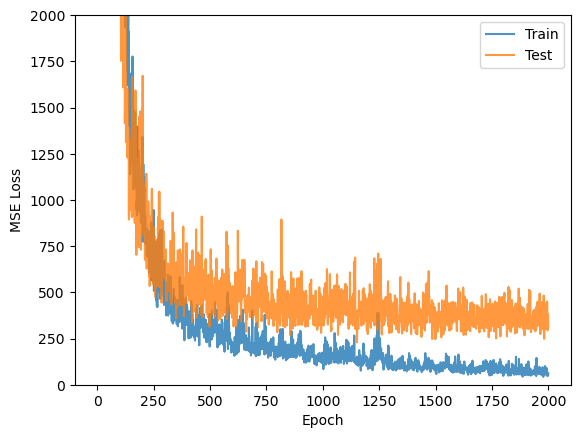

In [9]:
print('The best r2 value was:', best_R2)

fig, ax = plt.subplots()
ax.plot(train_loss_list, label='Train',alpha=0.8)
ax.plot(test_loss_list,label='Test',alpha=0.8)

ax.set_ylim(0,2000)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()

plt.show()

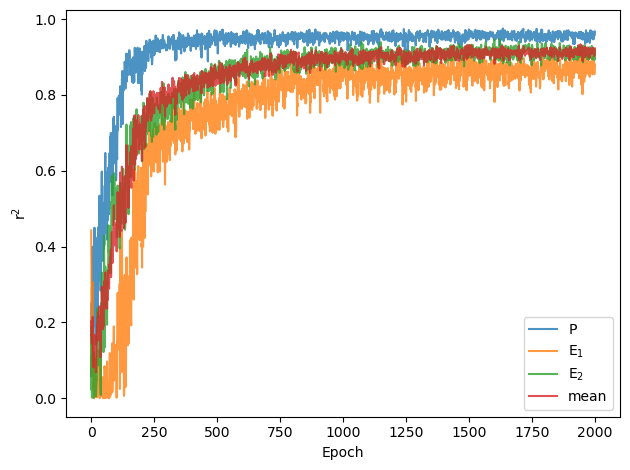

In [10]:
r2_array = np.array(r2_list)
labels = ['P', 'E$_1$', 'E$_2$', 'mean']

fig, ax = plt.subplots()
for i in range(r2_array.shape[1]):
    ax.plot(r2_array[:,i],label=labels[i],alpha=0.8)

ax.set_xlabel('Epoch')
ax.set_ylabel('r$^2$')
ax.legend()
ax.tick_params(axis='both')
plt.tight_layout()
plt.show()

## Plot the predicted vs. actuals

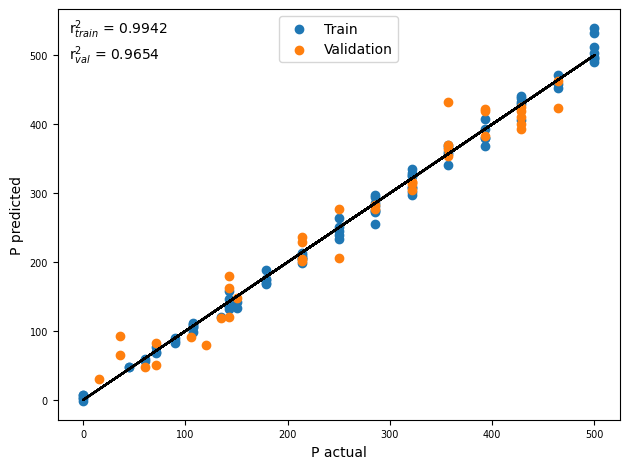

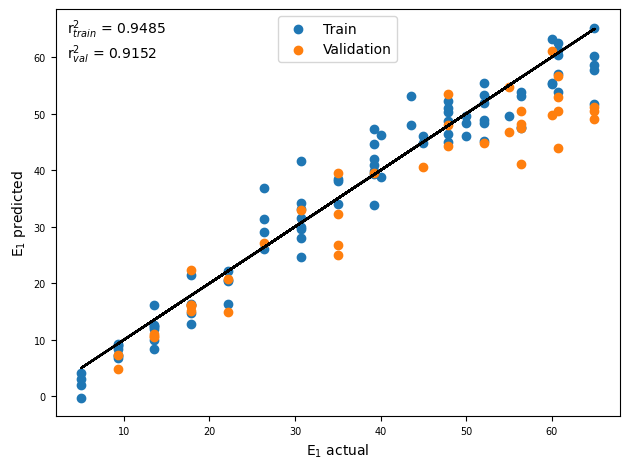

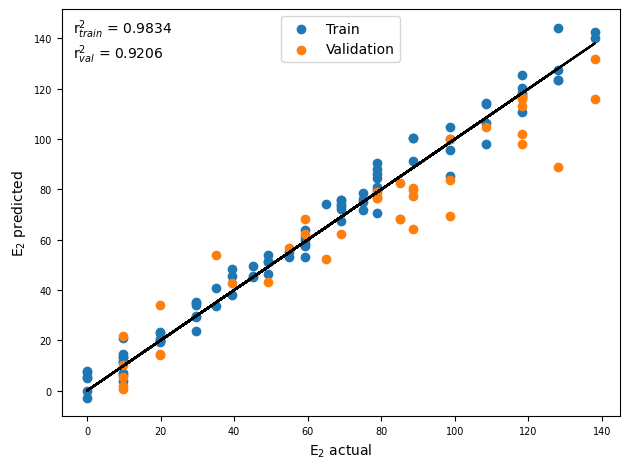

In [12]:
def plot_predictions(train_pred, train_actual, val_pred, val_actual, index, title):
    fig, ax = plt.subplots()
    
    r2_train = pearsonr(train_actual[:,index], train_pred[:,index])[0]**2
    r2_val = pearsonr(val_actual[:,index], val_pred[:,index])[0]**2
    
    ax.scatter(train_actual[:,index],train_pred[:,index],label='Train')
    ax.scatter(val_actual[:,index],val_pred[:,index],label='Validation')
    ax.plot(train_actual[:,index],train_actual[:,index],c='k')
    
    plt.text(0.02, 0.98, 'r$^2_{train}$ = %.4f\nr$^2_{val}$ = %.4f' % (r2_train,r2_val),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    ax.legend(loc='upper center')
        
    ax.set_xlabel('{} actual'.format(title))
    ax.set_ylabel('{} predicted'.format(title))
    ax.tick_params(axis='both')
    
    return ax

labels = ['P', 'E$_1$', 'E$_2$']

for i,label in enumerate(labels):
    ax = plot_predictions(best_train_predictions,best_train_actuals,
                     best_val_predictions, best_val_actuals,i,label)
    ax.tick_params(axis='both', labelsize=7)
    plt.tight_layout()